## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras.regularizers import l2

def build_mlp(input_shape,
              output_units = 10,
              num_neurons = [512, 256, 128],
              use_bn = True,
              drp_ratio = 0,
              l2_ratio = 0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units = n_units,
                                   kernel_regularizer = l2(l2_ratio),
                                   name = "hidden_layer" + str(i + 1))(input_layer)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
            
        else:
            x = keras.layers.Dense(units = n_units,
                                   kernel_regularizer = l2(l2_ratio),
                                   name = "hidden_layer" + str(i + 1))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units = output_units, activation = "softmax", name = "output")(x)
    model = keras.models.Model(inputs = [input_layer], outputs = [out])
    
    return model

In [15]:
LEARNING_RATE = 1e-3
MOMENTUM = 0.95
EPOCHS = 3
BATCH_SIZE = 128
USE_BN = [True, False]
DRP_RATIO = [0, 0.4, 0.8]
L2_RATIO = [0, 1e-6, 1e-8]

In [17]:
import keras.backend as K
results = {}

for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    K.clear_session()
    print("Numbers of exp: %i, with bn: %s, drp: %.2f, l2:%.2f" % (i, use_bn, drp_ratio,l2_ratio))
    model = build_mlp(input_shape = x_train.shape[1:], use_bn = use_bn, drp_ratio = drp_ratio, l2_ratio = l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr = LEARNING_RATE)
    #optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss = "binary_crossentropy", metrics = ["accuracy"], optimizer = optimizer)
    
    model.fit(x_train, y_train,
              epochs = EPOCHS,
              batch_size = BATCH_SIZE,
              validation_data = (x_test, y_test),
              verbose = 1,
              shuffle = True)
    
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss' : model.history.history["loss"],
                             'valid-loss' : model.history.history["val_loss"],
                             'train-accuracy' : model.history.history["accuracy"],
                             'valid-accuracy' : model.history.history["val_accuracy"]}
    

Numbers of exp: 0, with bn: True, drp: 0.00, l2:0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_

50000/50000 [==============================] - 12s 232us/step - loss: 0.1975 - accuracy: 0.9231 - val_loss: 0.3001 - val_accuracy: 0.8941
Numbers of exp: 3, with bn: True, drp: 0.40, l2:0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________


50000/50000 [==============================] - 14s 271us/step - loss: 0.2526 - accuracy: 0.9056 - val_loss: 0.2582 - val_accuracy: 0.9032
Epoch 3/3
50000/50000 [==============================] - 14s 274us/step - loss: 0.2409 - accuracy: 0.9087 - val_loss: 0.2443 - val_accuracy: 0.9084
Numbers of exp: 6, with bn: True, drp: 0.80, l2:0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
__________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 15s 300us/step - loss: 0.3739 - accuracy: 0.8904 - val_loss: 0.3071 - val_accuracy: 0.9000
Epoch 2/3
50000/50000 [==============================] - 14s 288us/step - loss: 0.3090 - accuracy: 0.8995 - val_loss: 0.2915 - val_accuracy: 0.9000
Epoch 3/3
50000/50000 [==============================] - 14s 289us/step - loss: 0.2962 - accuracy: 0.8997 - val_loss: 0.2827 - val_accuracy: 0.9003
Numbers of exp: 9, with bn: False, drp: 0.00, l2:0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 12s 243us/step - loss: 0.3088 - accuracy: 0.8997 - val_loss: 0.2910 - val_accuracy: 0.9003
Epoch 2/3
50000/50000 [==============================] - 12s 243us/step - loss: 0.2955 - accuracy: 0.8999 - val_loss: 0.2850 - val_accuracy: 0.9000
Epoch 3/3
50000/50000 [==============================] - 12s 245us/step - loss: 0.2914 - accuracy: 0.9000 - val_loss: 0.2858 - val_accuracy: 0.9000
Numbers of exp: 13, with bn: False, drp: 0.40, l2:0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 51

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 14s 286us/step - loss: 0.3439 - accuracy: 0.8981 - val_loss: 0.3264 - val_accuracy: 0.9000
Epoch 2/3
50000/50000 [==============================] - 14s 283us/step - loss: 0.3264 - accuracy: 0.9000 - val_loss: 0.3263 - val_accuracy: 0.9000
Epoch 3/3
50000/50000 [==============================] - 14s 281us/step - loss: 0.3263 - accuracy: 0.9000 - val_loss: 0.3263 - val_accuracy: 0.9000
Numbers of exp: 17, with bn: False, drp: 0.80, l2:0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 51

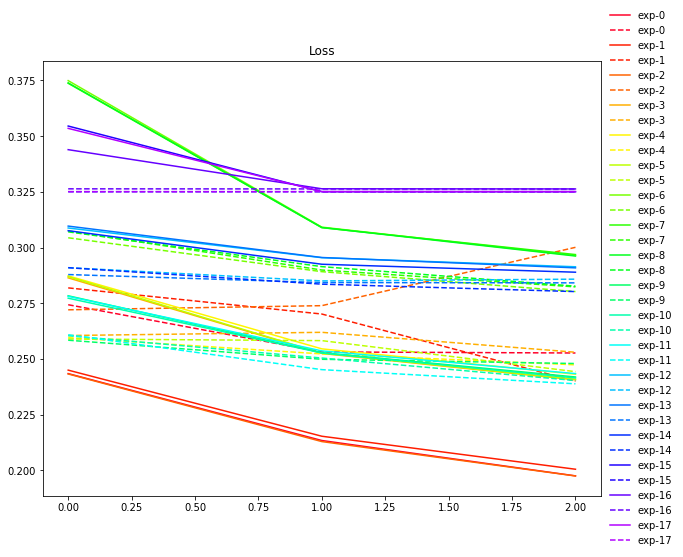

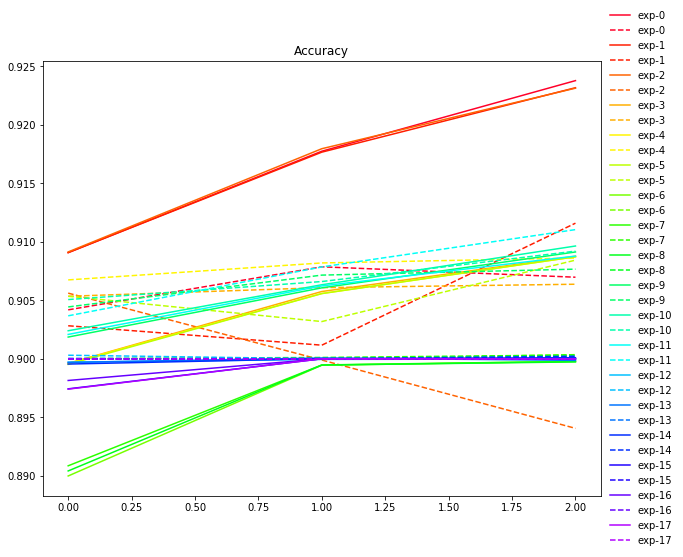

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

## 結論 : 第11組- bn: False, drp: 0.00, L2:0.00 的驗證表現較佳